In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical 
#from keras_tqdm import TQDMNotebookCallback
#
from tensorflow.keras.models import load_model
import h5py

# dont know if i need these
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dropout
from numpy.random import seed

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q "/content/gdrive/MyDrive/three.zip" -d file_destination

#print(os.listdir("archive"))
artists = pd.read_csv('/content/file_destination/artists.csv')
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_ = artists['name'].str.replace(' ', '_').values
# Explore images of top artists

images_dir = '/content/file_destination'
artists_subset = artists_[0:3]

artists_dirs = os.listdir(images_dir)
artists_[4] = "Al"

for name in artists_subset:
    if os.path.exists(os.path.join(images_dir, name)):
        os.path.join(images_dir, name)

    else:
        print("Did not find -->", os.path.join(images_dir, name))
        print(name)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace file_destination/Edgar_Degas/Edgar_Degas_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
artists_subset = artists_[0:3]
batch_size = 32
train_input_shape = (299, 299, 3)

# I use the same seed 
train_gen = ImageDataGenerator(validation_split=0.20, rescale=1./255., vertical_flip= True, horizontal_flip=True, 
                                 rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, 
                                 shear_range=10, zoom_range=0.1, channel_shift_range=0.1)

test_gen = ImageDataGenerator(validation_split=0.20, rescale=1./255.)

train_subset = train_gen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_subset.tolist(),
                                                    seed = 42
                                                   )

test_subset = test_gen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=False,
                                                    classes=artists_subset.tolist(),
                                                    seed = 42
                                                   )


Found 1616 images belonging to 3 classes.
Found 402 images belonging to 3 classes.


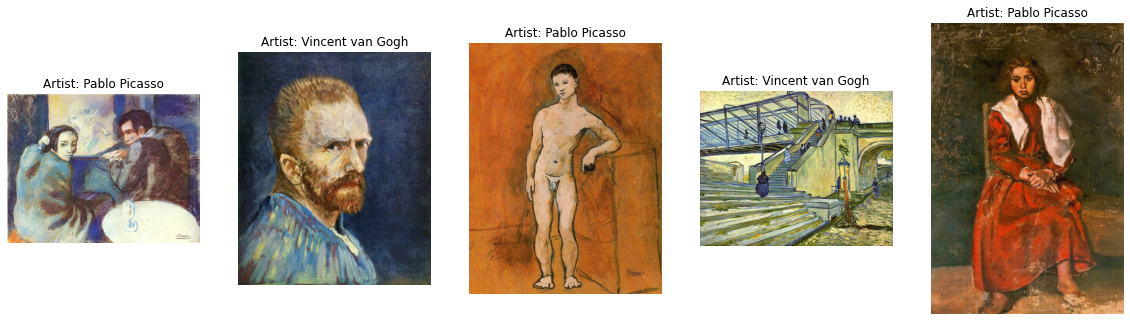

In [11]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_subset)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

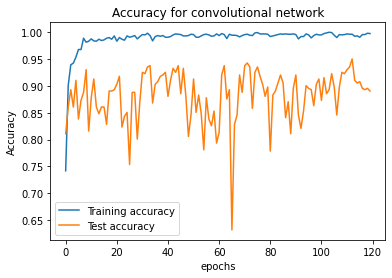

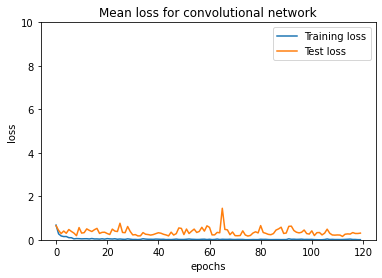

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

epochs = 120

base_model = InceptionV3(input_shape=train_input_shape, weights='imagenet', include_top=False, classes=3 , pooling = max )

X = base_model.output
X = Flatten()(X)

X = Dense(200)(X)
X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
output = Dense(3, activation='softmax')(X)



model = Model(inputs=base_model.input, outputs=output)
adam = optimizers.Adam(learning_rate=0.0001) 
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
hist = model.fit_generator(generator = train_subset, validation_data = test_subset, epochs = epochs,  verbose = 0)

train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']
xc         = range(epochs)

plt.figure()
plt.plot(xc, train_acc, label = 'Training accuracy')
plt.plot(xc, val_acc, label = 'Test accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for convolutional network')
plt.show()

plt.figure()
plt.plot(xc, train_loss, label = 'Training loss')
plt.plot(xc, val_loss, label = 'Test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(top = 10, bottom = 0)
plt.legend()
plt.title('Mean loss for convolutional network')
plt.show()